# Steepest decent with exact line search

This notebook presents the method of steepest decent with exact line search for iteratively solving linear linear systems (Golub and Van Loan, 2013, p. 627).

### References

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

### Introduction

Sometimes, the associated matrix of a given linear system is so large that our previous factorization methods are computatinally inefficient. In these cases, a preferable strategy consists in using *iterative methods*. An iterative method for solving

<a id='eq1'></a>
$$
\mathbf{A} \, \mathbf{p} = \mathbf{d} \quad , \tag{1}
$$

where $\mathbf{A}$ is an $N \times N$ matrix, by generating a sequence of approximate solutions $\mathbf{p}_{k}$ that converges to the solution

<a id='eq2'></a>
$$
\tilde{\mathbf{p}} = \mathbf{A}^{-1} \mathbf{d} \quad . \tag{2}
$$

Typically, the matrix $\mathbf{A}$ is involved only in the context of matrix-vector multiplication and that is what makes this framework attractive when $\mathbf{A}$ is large and sparse. The critical attributes of an terative method include the rate of convergence, the amount of computation per step, the volume of required storage, and the pattern of memory access (Golub and Van Loan, 2013, p. 611).

Here, our discussion is limited to systems involving symmetric and positive-definite matrices $\mathbf{A}$.

### Theoretical aspects

Solve the linear system above ([equation 1](#eq1)) is equivalent to minimize the quadratic function

<a id='eq3'></a>
$$
\Psi(\mathbf{p}) = \frac{1}{2}\mathbf{p}^{\top}\mathbf{A}\mathbf{p} - \mathbf{p}^{\top}\mathbf{d} \quad , \tag{3}
$$

that is convex function. The $j$th element of its gradient is given by

<a id='eq4a'></a>
$$
\begin{split}
\frac{\partial}{\partial \, p_{j}} \Psi (\mathbf{p}) 
&= \frac{1}{2}\mathbf{u}_{j}^{\top} \mathbf{A} \mathbf{p} + \frac{1}{2}\mathbf{p}^{\top} \mathbf{A} \mathbf{u}_{j} - \mathbf{u}_{j}^{\top} \mathbf{d} \\
&= \mathbf{u}_{j}^{\top} \mathbf{A} \mathbf{p} - \mathbf{u}_{j}^{\top} \mathbf{d}
\end{split} \quad . \tag{4a}
$$

By using [equation 4a](#eq4a), we show that the gradient of $\Psi(\mathbf{p})$ ([equation 3](#eq3)) is given by

<a id='eq4b'></a>
$$
\nabla \Psi(\mathbf{p}) = \mathbf{A}\mathbf{p} - \mathbf{d} \quad . \tag{4b}
$$

### Steepest decent method with exact line search

Given an approximation $\mathbf{p}_{0}$ for $\tilde{\mathbf{p}}$ ([equation 2](#eq2)), we can compute a new vector $\mathbf{p}_{1}$ given by

<a id='eq5'></a>
$$
\mathbf{p}_{1} = \mathbf{p}_{0} - \mu \, \nabla \Psi(\mathbf{p}_{0}) \quad , \tag{5}
$$

where $\nabla \Psi(\mathbf{p}_{0})$ is the gradient of $\Psi(\mathbf{p})$ ([equation 4](#eq4)) evaluated at $\mathbf{p}_{0}$ and $\mu$ is a positive constant minimizing 

<a id='eq6'></a>
$$
\Psi \left( \mathbf{p}_{0} - \mu \nabla \Psi(\mathbf{p}_{0}) \right) \quad . \tag{6}
$$

Estimating a parameter $\tilde{\mu}$ minimizing [equation 6](#eq6) represents an *exact line search* problem (Golub an Van Loan, 2013, p. 627). It can be show that 

<a id='eq7'></a>
$$
\tilde{\mu} = \frac{\nabla \Psi(\mathbf{p}_{0})^{\top}\nabla \Psi(\mathbf{p}_{0})}
{\nabla \Psi(\mathbf{p}_{0})^{\top} \, \mathbf{A} \, \nabla \Psi(\mathbf{p}_{0})} \quad . \tag{7}
$$

In [1]:
def sd_lsearch(A, dobs, p0, tol, itmax):
    '''
    Solve a linear system by using the method of
    steepest decent with exact line seach, where A
    is an N x N symmetric and positive definite matrix.
    
    Parameters:
    -----------
    A : array 2D
        Symmetric positive definite N x N matrix.
    dobs : array 1D
        Observed data vector with N elements.
    p0 : array 1D
        Initial approximation of the solution p.
    tol : float
        Positive scalar controlling the termination criterion.
    
    Returns:
    --------
    p : array 1D
        Solution of the linear system.
    dpred : array 1D
        Predicted data vector produced by p.
    goal_function_values : list
        Values of the goal function along iterations.
    '''

    A = np.asarray(A)
    dobs = np.asarray(dobs)
    p0 = np.asarray(p0)
    assert A.shape[0] == A.shape[1], 'A must be square'
    assert dobs.size == A.shape[0] == p0.size, 'A order, dobs size and p0 size must be the same'
    assert np.isscalar(tol) & (tol > 0.), 'tol must be a positive scalar'
    assert isinstance(itmax, int) & (itmax > 0), 'itmax must be a positive integer'

    N = dobs.size
    p = p0.copy()
    dpred = np.dot(A, p)
    grad = dpred - dobs
    goal_function_values = []
    for iteration in range(itmax):
        mu = np.dot(grad,grad)/np.linalg.multi_dot([grad, A, grad])
        p -= mu*grad
        dpred = np.dot(A, p)
        grad = dpred - dobs
        goal_function = np.sum(grad*grad)
        goal_function_values.append(goal_function)
        if goal_function < tol:
            break
    return p, dpred, goal_function_values

In [2]:
import numpy as np
from scipy.signal import ricker
import matplotlib.pyplot as plt

In [3]:
N = 300

In [4]:
np.random.seed(10)

In [5]:
A = 10*np.random.rand(N,N)
A = np.round(np.dot(A.T, A), decimals=3)

In [6]:
pulses = np.zeros(N)
N_pulses = 10
indices_pulses = np.random.randint(low=0, high=N+1, size=N_pulses)
values_pulses = 10*np.random.rand(N_pulses)
pulses[indices_pulses] = values_pulses
wavelet = ricker(points=N, a=3)
p_true = np.convolve(a=wavelet, v=pulses, mode='same')

In [7]:
dobs = np.dot(A, p_true)

In [8]:
tolerance = 1e-2

In [9]:
p_initial = np.zeros(N)+0.01

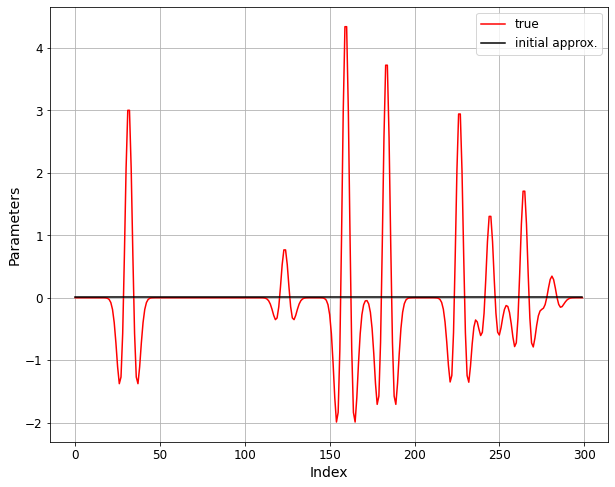

In [10]:
plt.figure(figsize=(10,8))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [11]:
p_estimated, dpred, phi_values = sd_lsearch(A=A, dobs=dobs, 
                                            p0=p_initial, tol=tolerance, itmax=7*N)

In [12]:
num_iterations = np.arange(1, len(phi_values)+1)

In [13]:
d_initial = np.dot(A, p_initial)

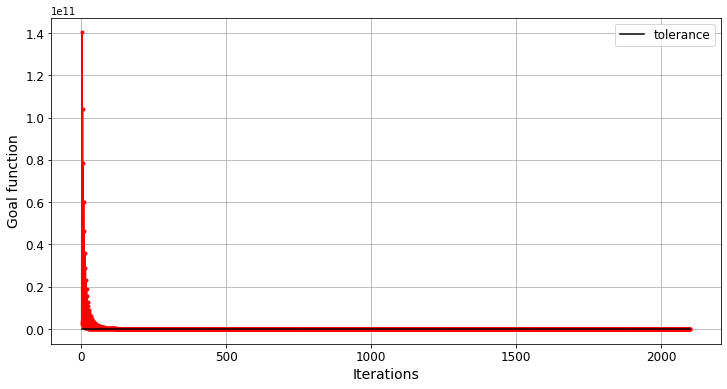

In [14]:
plt.figure(figsize=(12,6))
plt.plot(num_iterations, phi_values, 'r.-')
plt.plot([np.min(num_iterations), np.max(num_iterations)],
         [tolerance, tolerance], 'k-', label = 'tolerance')
plt.ylabel('Goal function', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

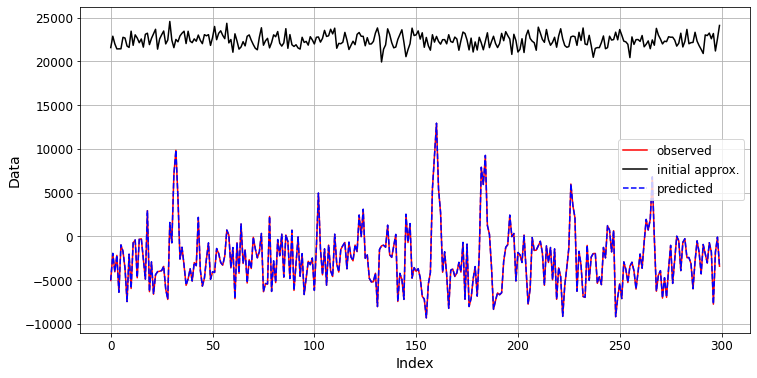

In [15]:
plt.figure(figsize=(12,6))
plt.plot(dobs, 'r-', label = 'observed')
plt.plot(d_initial, 'k-', label = 'initial approx.')
plt.plot(dpred, 'b--', label = 'predicted')
plt.ylabel('Data', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

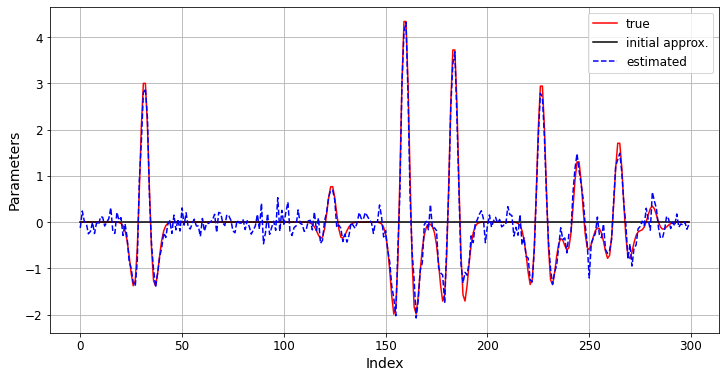

In [16]:
plt.figure(figsize=(12,6))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.plot(p_estimated, 'b--', label = 'estimated')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()